In [1]:
from google.colab import drive
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import logging
logging.getLogger("sklearn").setLevel(logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_url = '/content/sample_data/pp5i_train.gr.csv'
test_url = '/content/sample_data/pp5i_test.gr.csv'
class_url = '/content/sample_data/pp5i_train_class.txt'

In [4]:
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)
class_df = pd.read_csv(class_url)

class_np = class_df.to_numpy()

le = preprocessing.LabelEncoder()
le.fit(class_np)
train_class = le.transform(class_np)

 Training Data:  
                  SNO    1   2    3    4    5    6   7    8   9  ...   61   62  \
2506       U00921_at   20  20   20   20   20   20  20   20  20  ...   26   20   
6528     U59877_s_at   20  45   20   20   20   20  20   20  20  ...  285  341   
6663   AF000424_s_at   20  20   20   20   20   20  20   20  20  ...   20   20   
5503     D13631_s_at   21  54   20   31   20   20  20   20  20  ...  114  141   
3688       U79242_at   20  20   20   20   32   20  20   20  20  ...   31   20   
...              ...  ...  ..  ...  ...  ...  ...  ..  ...  ..  ...  ...  ...   
6861  X54489_rna1_at   20  20   20   20   20   20  20   20  20  ...   20   20   
1241       L13042_at   50  53   48   42   40   43  61   30  26  ...   41   36   
1658  M14159_cds2_at   48  85  108   27   54   46  24   20  20  ...   82   78   
3355       U56816_at  122  73   79  120  151  119  67  100  40  ...   74  103   
4156       X51757_at   20  20   20   21   20   20  27   20  20  ...   52   20   

       6

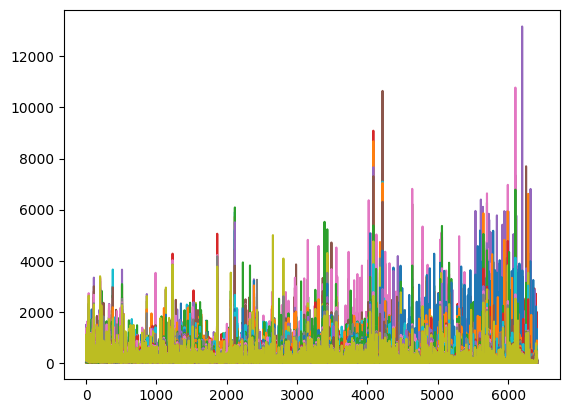

In [5]:
ttdf_sno=train_df['SNO']
ttdf_rem=train_df.iloc[:,1:]
ttdf_rem=ttdf_rem.clip(20,16000)

tsdf_sno=test_df['SNO']
tsdf_rem=test_df.iloc[:,1:]
tsdf_rem=tsdf_rem.clip(20,16000)


ttdf_cal = ttdf_rem.max(axis=1)/ttdf_rem.min(axis=1)
ttdf_cal = abs(ttdf_cal)
del_ind = ttdf_cal[ttdf_cal<2].index

train_tdf = pd.concat([ttdf_sno.drop(del_ind),ttdf_rem.drop(del_ind)],axis=1,sort=False)
test_tdf = pd.concat ([tsdf_sno.drop(del_ind),tsdf_rem.drop(del_ind)],axis=1,sort=False)

from sklearn.feature_selection import f_classif
tTrain_tdf = train_tdf.T[1:]
new_train = f_classif(tTrain_tdf,train_class)
train_tdf['rank']=new_train[0]
test_tdf['rank']=new_train[0]

train_tdf=train_tdf.sort_values('rank',ascending=False)
test_tdf=test_tdf.sort_values('rank',ascending=False)

print("\033[4m Training Data: \033[0m \n",train_tdf,"\n")
print("\033[4m Testing Data: \033[0m \n",test_tdf,"\n")

training_data = train_tdf.drop('SNO',axis=1)
training_data = training_data.drop('rank',axis=1)
training_data = training_data.to_numpy()

p=plt.plot(training_data)

In [6]:
import numpy as np
from numpy import savetxt
from numpy import genfromtxt

def unique_rows(a):
    order = np.lexsort(a.T)
    a = a[order]
    diff = np.diff(a, axis=0)
    ui = np.ones(len(a), 'bool')
    ui[1:] = (diff != 0).any(axis=1)
    return a[ui]

NList = [2,4,6,8,10,12,15,20,25,30]

for N in NList:
  x_train = train_tdf.drop('SNO',axis=1)
  x_train = x_train.drop('rank',axis=1)
  x_train = x_train.to_numpy()
  x_train = x_train[:N].T
  x_trainN = np.c_[x_train, train_class]
  x_trainN=unique_rows(x_trainN)

  filename="pp5i_train.top"+str(N)+".gr.csv"
  savetxt(filename, x_trainN, delimiter=',')

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


CList = ["GaussianNB","DecisionTreeClassifier","KNeighborsClassifier","MLP","ExtraTreesClassifier"]

funcdict = {
  'GaussianNB': GaussianNB,
  'DecisionTreeClassifier': DecisionTreeClassifier,
  'KNeighborsClassifier': KNeighborsClassifier,
  'MLP': MLPClassifier,
  'ExtraTreesClassifier': ExtraTreesClassifier,
}

arr = np.zeros((10,6))
row =0


for N in NList:
  NRow = list()
  NRow.append(N)

  col =0
  arr[row][col]=N

  filename="pp5i_train.top"+str(N)+".gr.csv"
  data_arr = np.genfromtxt(filename,delimiter=',')
  x_trainNT = data_arr[:,:-1]
  y_trainNT = data_arr[:,-1]

  for C in funcdict:
    if C=='KNeighborsClassifier':
      clf = funcdict[C](3)
    elif C=='ExtraTreesClassifier':
      clf = funcdict[C](n_estimators=350)
    elif C=='MLP':
      clf = MLPClassifier(activation = 'relu', solver = 'sgd', hidden_layer_sizes= (25, 25),random_state = 1, max_iter=250)
    else:
      clf = funcdict[C]()


    clf.fit(x_trainNT,y_trainNT)

    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(clf, x_trainNT, y_trainNT,cv=5)
    NRow.append(scores.mean())
    col+=1
    arr[row][col]=1-scores.mean()
  row+=1

In [8]:
CList = ["GaussianNB","DecisionTreeClassifier","KNeighborsClassifier","MLP","ExtraTreesClassifier"]

NMList = list()
for i in arr[:,1:]:
  NMList.append(np.mean(i))

CMList = list()
for i in range(arr.shape[1]-1):
  CMList.append(np.mean(arr[:,i+1]))

maxN = min(NMList)
mi=[i for i, j in enumerate(NMList) if j == maxN]
maxNV = NList[mi[0]]

maxC = min(CMList)
mi=[i for i, j in enumerate(CMList) if j == maxC]
maxCV = CList[mi[0]]

filename="pp5i_train.top"+str(maxNV)+".gr.csv"
data_arr = np.genfromtxt(filename,delimiter=',')
best_genes_set = data_arr[:,:-1]
best_genes_cls = data_arr[:,-1]
filename="pp5i_train.bestN.csv"
savetxt(filename, best_genes_set, delimiter=',')

x_test = test_tdf.drop('SNO',axis=1)
x_test = x_test.drop('rank',axis=1)
x_test = x_test.to_numpy()
x_test = x_test[:maxNV].T
filename="pp5i_test.bestN.csv"
savetxt(filename, x_test, delimiter=',')

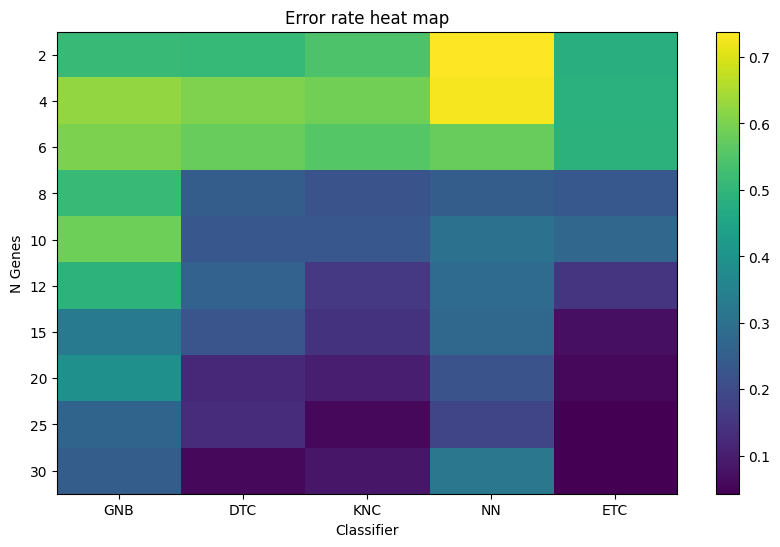

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))

hm=plt.imshow(arr[:,1:],aspect='auto')
cb=plt.colorbar()

xlocs, xlabels=plt.xticks()
ylocs, ylabels=plt.yticks()

new_xlocs=[0,1,2,3,4]
new_xlabels=['GNB','DTC','KNC','NN','ETC']
# new_xlabels=CList
xt = plt.xticks(new_xlocs,new_xlabels)

new_ylocs=[0,1,2,3,4,5,6,7,8,9]

new_ylabels=NList
yt = plt.yticks(new_ylocs,new_ylabels)

titl = plt.title("Error rate heat map")
yl = plt.ylabel("N Genes")
yl = plt.xlabel("Classifier")

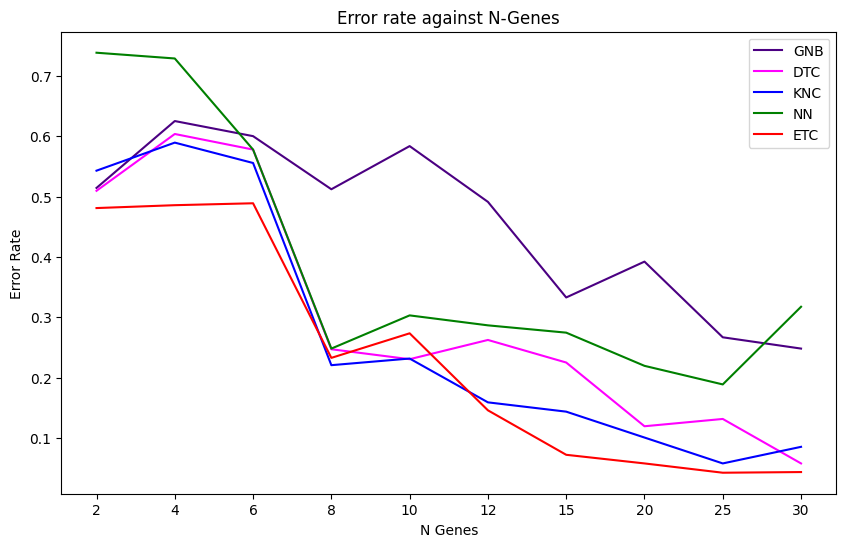

In [10]:
err_arr = arr[:,1:]

cdict = {0: 'indigo',1: 'magenta', 2: 'blue', 3: 'green', 4: 'red'}
plt.figure(figsize = (10,6))
for i in range(err_arr.shape[1]):
  plt.plot(err_arr[:,i],c = cdict[i], label = new_xlabels[i])
lg = plt.legend()
xt = plt.xticks([0,1,2,3,4,5,6,7,8,9],new_ylabels)
titl = plt.title("Error rate against N-Genes")
yl = plt.xlabel("N Genes")
yl = plt.ylabel("Error Rate")

In [11]:
  filename="pp5i_train.bestN.csv"
  data_arr = np.genfromtxt(filename,delimiter=',')
  x_trainNT = data_arr
  y_trainNT = best_genes_cls

  clf = funcdict[maxCV]()

  if maxCV=='KNeighborsClassifier':
    clf = funcdict[C](3)
  elif maxCV=='ExtraTreesClassifier':
    clf = funcdict[C](n_estimators=350)
  elif maxCV=='MLP':
    clf = MLPClassifier(activation = 'relu', solver = 'sgd', hidden_layer_sizes= (25, 25),random_state = 1, max_iter=250)
  else:
    clf = funcdict[C]()

  clf.fit(x_trainNT,y_trainNT)

  from sklearn.model_selection import cross_val_score
  scores = cross_val_score(clf, x_trainNT, y_trainNT,cv=5)

  print("Best N         : ",maxNV)
  print("Best Clasifier : ",maxCV)
  print("Best Accuracy  : ",np.mean(scores))

Best N         :  25
Best Clasifier :  ExtraTreesClassifier
Best Accuracy  :  0.9571428571428571


In [12]:
filename="pp5i_test.bestN.csv"
x_testN = np.genfromtxt(filename,delimiter=',')

num_out = clf.predict(x_testN)

test_class = le.inverse_transform(num_out.astype(int))

print("Test dataset predictions :\n",test_class)

Test dataset predictions :
 ['MGL' 'EPD' 'MED' 'MED' 'EPD' 'MED' 'MED' 'MED' 'EPD' 'JPA' 'JPA' 'MED'
 'MED' 'MED' 'MED' 'MED' 'EPD' 'MED' 'MED' 'RHB' 'RHB' 'MED' 'MED']


In [13]:
disease_mapping = {
    'MED': 'Mediastinal Germ Cell Tumor',
    'EPD': 'Ependymoma',
    'JPA': 'Juvenile Pilocytic Astrocytoma',
    'MGL': 'Meningioma',
    'RHB': 'Rhabdomyosarcoma'
}

probabilities = clf.predict_proba(x_testN)

for i, probs in enumerate(probabilities):
    max_prob_index = np.argmax(probs)
    highest_prob_class = disease_mapping[le.classes_[max_prob_index]]
    highest_prob_value = probs[max_prob_index] * 100
    print(f"Sample {i+1}: {highest_prob_class} with {highest_prob_value:.2f}% chance")

Sample 1: Meningioma with 76.86% chance
Sample 2: Ependymoma with 73.71% chance
Sample 3: Mediastinal Germ Cell Tumor with 97.43% chance
Sample 4: Mediastinal Germ Cell Tumor with 99.14% chance
Sample 5: Ependymoma with 68.29% chance
Sample 6: Mediastinal Germ Cell Tumor with 87.43% chance
Sample 7: Mediastinal Germ Cell Tumor with 89.14% chance
Sample 8: Mediastinal Germ Cell Tumor with 82.00% chance
Sample 9: Ependymoma with 78.00% chance
Sample 10: Juvenile Pilocytic Astrocytoma with 89.43% chance
Sample 11: Juvenile Pilocytic Astrocytoma with 95.43% chance
Sample 12: Mediastinal Germ Cell Tumor with 100.00% chance
Sample 13: Mediastinal Germ Cell Tumor with 96.29% chance
Sample 14: Mediastinal Germ Cell Tumor with 99.14% chance
Sample 15: Mediastinal Germ Cell Tumor with 95.71% chance
Sample 16: Mediastinal Germ Cell Tumor with 98.86% chance
Sample 17: Ependymoma with 39.14% chance
Sample 18: Mediastinal Germ Cell Tumor with 71.71% chance
Sample 19: Mediastinal Germ Cell Tumor with

In [26]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random

disease_mapping = {
    'MGL': 'Mucolipidosis',
    'EPD': 'Epidermolysis Bullosa',
    'MED': 'Medullary Thyroid Carcinoma',
    'JPA': 'Juvenile Pilocytic Astrocytoma',
    'RHB': 'Rhabdomyosarcoma'
}

def get_user_input():
    while True:  # Keep asking for input until valid
        try:
            age = int(input("Enter Patient Age: "))
            if 0 <= age <= 100:
                genes_expression = [random.randint(10, 500) for _ in range(25)]
                print(f"Generated gene expression values: {' '.join(map(str, genes_expression))}")
                return np.array(genes_expression).reshape(1, -1)
            else:
                print("Invalid Age Input. Please enter a valid age (0-100).")
        except ValueError:
            print("Please enter a valid integer for age.")

if __name__ == "__main__":
    x_testN = get_user_input()

    # Assuming clf and le are defined
    num_out = clf.predict(x_testN)
    predicted_probabilities = clf.predict_proba(x_testN)

    test_class_abbrev = le.inverse_transform(num_out.astype(int))
    test_class_full = disease_mapping[test_class_abbrev[0]]

    max_probability = np.max(predicted_probabilities)

    print(f"Predicted Disease: {test_class_full} with probability: {max_probability * 100:.2f}%")

Enter Patient Age: 101
Invalid Age Input. Please enter a valid age (0-100).
Enter Patient Age: 95
Generated gene expression values: 86 20 317 81 196 347 225 148 356 380 113 96 257 48 336 258 478 239 100 72 273 113 89 331 430
Predicted Disease: Juvenile Pilocytic Astrocytoma with probability: 30.57%
